### Задание 3
Есть А/Б тест направленный на конверсию в покупку (подписки и/или платных фильмов). % что либо купивших в обоих группах одинаковый. Средний чек разный. Каким способом можно проверить, что разница не случайна (с использованием sql и/или python).

In [1]:
# Импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

from tqdm.auto import tqdm

plt.style.use('ggplot')

#### Загрузка данных
Загрузим предварительно подготовленные данные: две группы "a" и "b" по 5000 пользователей. В каждой группе по 2000 заплативших уникальных пользователей.

In [2]:
# Загрузим тестовые данные

df = pd.read_csv('test_sample.csv', sep=';')

In [3]:
df.head()

,user_id,revenue,test_group
0,1,599,a
1,2,599,a
2,3,599,a
3,4,599,a
4,5,599,a


In [4]:
df.groupby('test_group', as_index=False) \
  .agg({'user_id': 'count'})

,test_group,user_id
0,a,5000
1,b,5000


In [5]:
df.query('revenue > 0') \
  .groupby('test_group', as_index=False) \
  .agg({'user_id': 'count'})

,test_group,user_id
0,a,2000
1,b,2000


Посчитаем cредний чек по каждой группе. Т.к. у нас по каждому пользователю только одна покупка, то средний чек будет равен ARPPU

In [6]:
df.query('revenue > 0') \
  .groupby('test_group', as_index=False) \
  .agg({'revenue': 'mean'}) \
  .rename(columns={'revenue': 'ARPPU'})

,test_group,ARPPU
0,a,510.1055
1,b,502.1005


Посмотрим на распределение чеков в обеих группах

In [7]:
# Предварительно разделим наш датафрейм на два в соответствии с тестовыми группами
a_df = df.query('test_group == "a" & revenue != 0')
b_df = df.query('test_group == "b" & revenue != 0')

# Проверим размеры выборок
a_df.shape, b_df.shape

((2000, 3), (2000, 3))

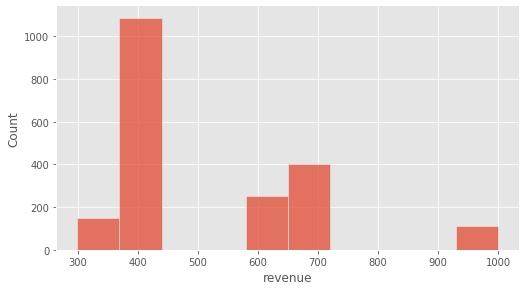

In [8]:
# Распределение чеков в группе 'a'
x_a = sns.displot(x='revenue', data=a_df, bins=10)
x_a.fig.set_size_inches(8, 4)

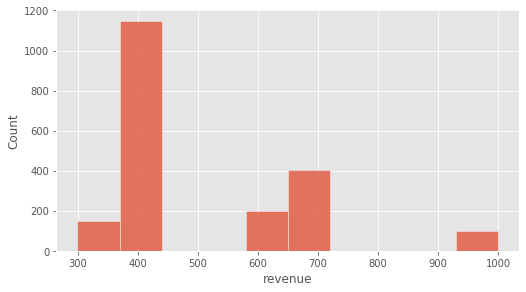

In [9]:
# Распределение чеков в группе 'b'
x_b = sns.displot(x='revenue', data=b_df, bins=10)
x_b.fig.set_size_inches(8, 4)

Обе выборки имеют не нормальное распределение.

### Проверка стат. значимости различий средних чеков

Проверить гипотезу о случайности/неслучайности различия среднего чека в группах можно с помощью двух способов: t-test и Bootstrap. И t-test и Bootstrap применимы при нормальном распределении исследуемой метрики (в данном случае ср. чек), помимо этого t-test также требует гомогенности дисперсий выборок.

1) Проверим нормальность распределения среднего чека:

In [10]:
# Функция построения распределения целевой метрики

def check_metric(
        data_column,  # числовые значения выборки
        boot_it=1000,  # количество бутстрэп-подвыборок, по умолчанию 1000
        statistic=np.mean,  # интересующая нас статистика, по умолчанию np.mean
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples = data_column.sample(
            len(data_column),
            replace=True  # параметр возвращения
        ).values

        boot_data.append(statistic(samples))  # применяем статистику к подвыборке

    pd_boot_data = pd.DataFrame(boot_data)

    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)

    plt.style.use('ggplot')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

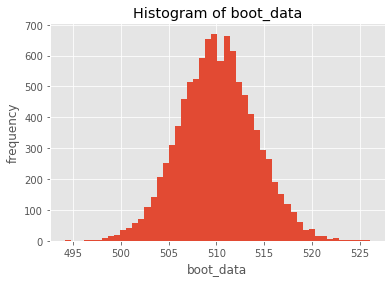

In [11]:
# Проверяем распределение среднего чека в группе "а"

check_metric(a_df.revenue, 
             boot_it = 10000, 
             statistic=np.mean
            )

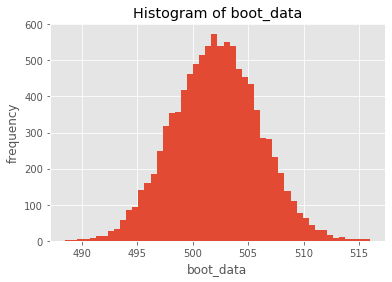

In [12]:
# Проверяем распределение среднего чека в группе "b"

check_metric(b_df.revenue, 
             boot_it = 10000, 
             statistic=np.mean
            )

Как видно из обоих графиков средний чек имеет нормальное распределение.

2) Для проверки гомогенности дисперсий используем непараметрический тест Левена (т.к. наши выборки имеют не нормальное распределение). Принимаем в качестве нулевой гипотезы равенство дисперсий в выборках, уровень значимости для теста 0,05.

In [14]:
stats.levene(a_df.revenue, b_df.revenue, center='median')

LeveneResult(statistic=2.325714294101176, pvalue=0.12733089219689542)

Т.к. в результате теста p-value оказался выше уровня значимости, то нулевая гипотеза не отклоняется. Дисперсии в выборках "а" и "b" одинаковы.

Это значит, что мы можем применять t-test и бутстрап, для выявления стат. значимых различий среднего чека в группах "а" и "b"

### T-тест

За нулевую гипотезу принимаем отсутсвие стат. значимых различий в среднем чеке. Устанавливаем уровень значимости равным 0.05

In [15]:
# Проводим t-test

stats.ttest_ind(a_df.revenue, b_df.revenue)

Ttest_indResult(statistic=1.4373443251230011, pvalue=0.1506984368628269)

T-статистика оказалась равна 1.43, p-value больше уровня значимости, поэтому отклонить нулевую гипотезу не можем - стат. значимых различий в среднем чеке нет.

### Bootstrap

За нулевую гипотезу также принимаем отсутсвие стат. значимых различий в среднем чеке. Уровень значимости также 0.05.

In [16]:
# Функция, которая позволит проверять гипотезы с помощью Bootstrap


def get_bootstrap(
        data_column_1,  # числовые значения первой выборки
        data_column_2,  # числовые значения второй выборки
        boot_it=1000,  # количество бутстрэп-подвыборок, по умолчанию 1000
        statistic=np.mean,  # интересующая нас статистика, по умолчанию np.mean
        bootstrap_conf_level=0.95  # уровень значимости, по умолчанию 0.95
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True  # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values

        boot_data.append(statistic(samples_1) - statistic(samples_2))  # применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)

    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

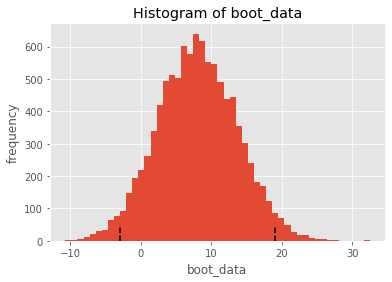

In [17]:
# Проверка гипотезы

booted_data_dict = get_bootstrap(a_df.revenue,  # revenue из группы "a"
                                 b_df.revenue,  # revenue из группы "b"
                                 boot_it=10000,  # количество бутстрэп подвыборок
                                 statistic=np.mean,  # в данном варианте считаем статистику np.mean
                                 bootstrap_conf_level=0.95  # уровень значимости
                                 )

In [18]:
# Доверительный интервал для разницы средних значений двух выборок
booted_data_dict['ci']

,0
0.025,-2.903550
0.975,19.073025


In [19]:
# p-value
booted_data_dict["p_value"]

0.15395090668916062

Т.к. 0 входит в доверительный интервал для разницы средних чеков двух выборок, а также p-value больше уровня значимости, то отклонить нулевую гипотезу не можем - средний чек в двух группах стат. значимо  не различается.